# Image Classification Batch Inference with Huggingface Vision Transformer

In this example, we will introduce how to use [Ray Data](data) for **large-scale image classification batch inference with multiple GPU workers.**

In particular, we will:
- Load the [Imagenette](https://github.com/fastai/imagenette) dataset from an S3 bucket and create a {class}`Ray Dataset <ray.data.dataset.Dataset>`.
- Load a pretrained Vision Transformer from Huggingface that's been trained on [ImageNet](https://www.image-net.org/).
- Use [Ray Data](data) to preprocess the dataset and do model inference in parallel across multiple GPUs.
- Evaluate the predictions and save results to S3/local disk.

_Note: This example will still work even if you do not have GPUs available, but overall performance will be slower._

To run this example, you will need to install the following:

In [1]:
!pip install -q -U "ray[data]" transformers

## Step 1: Reading the Dataset from S3

[Imagenette](https://github.com/fastai/imagenette) is a subset of [ImageNet](https://www.image-net.org/) with 10 classes. This dataset has been hosted in a public S3  (`s3://anonymous@air-example-data-2/imagenette2/val/`). Since we are only doing inference here, we load in just the validation split.

Here, we use {meth}`ray.data.read_images <ray.data.read_images>` to load the validation set from S3. [Ray Data](data) also supports reading from a variety of other [datasources and formats](loading_data).

In [4]:
import ray

s3_uri = "s3://anonymous@air-example-data-2/imagenette2/val/"

ds = ray.data.read_images(
    s3_uri, mode="RGB"
)
ds


Dataset(num_rows=3925, schema={image: numpy.ndarray(ndim=3, dtype=uint8)})

Inspecting the schema, we can see that there is a column "image" in the dataset that contains the images stored as Numpy arrays.

In [5]:
ds.schema()

Column  Type
------  ----
image   numpy.ndarray(ndim=3, dtype=uint8)

## Step 2: Inference on a single batch

Next, we can do inference on a single batch of data, using a pre-trained Vision Transformer from Huggingface following [this Huggingface example](https://huggingface.co/docs/transformers/tasks/image_classification#inference). 

Let’s get a batch of 10 from our dataset. The batch is a dictionary for column names to data, here we have one column "image". Each of the 10 images in the batch is represented as a Numpy array.

In [6]:
single_batch = ds.take_batch(10)
print(f"Num columns: {len(single_batch['image'])}")
print(f"Image shape: {single_batch['image'][0].shape}")

2024-03-13 11:15:48,780	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-03-13_10-32-07_109388_95283/logs/ray-data
2024-03-13 11:15:48,780	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage] -> LimitOperator[limit=10]



- ReadImage 1:   0%|          | 0/200 [00:00<?, ?it/s]

- limit=10 2:   0%|          | 0/200 [00:00<?, ?it/s]

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

Num columns: 10
Image shape: (160, 213, 3)


We can visualize the first image from this batch using PIL.

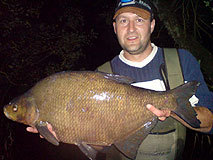

In [1]:
from PIL import Image

img = Image.fromarray(single_batch["image"][0])
img

Now, let’s create a Huggingface Image Classification pipeline from a pre-trained Vision Transformer model.

We specify the following configurations:
1. Set the device to "cuda:0" to use GPU for inference
2. We set the batch size to 10 so that we can maximize GPU utilization and do inference on the entire batch at once. 

We also convert the Numpy arrays representing images into PIL Images since that's what Huggingface expects.

From the results, we see that all of the images in the batch are correctly being classified as ["tench"](https://en.wikipedia.org/wiki/Tench) which is a type of fish.

In [8]:
from transformers import pipeline
from PIL import Image

# Note, you must have GPUs on your head node in order to do this with GPUs.
# If doing CPU inference, set device="cpu" instead.
classifier = pipeline("image-classification", model="google/vit-base-patch16-224", device="cuda:0")
outputs = classifier([Image.fromarray(image_array) for image_array in single_batch["image"]], top_k=1, batch_size=10)
del classifier # Delete the classifier to free up GPU memory.
outputs

[[{'label': 'tench, Tinca tinca', 'score': 0.991676926612854}],
 [{'label': 'tench, Tinca tinca', 'score': 0.9995598196983337}],
 [{'label': 'tench, Tinca tinca', 'score': 0.9996077418327332}],
 [{'label': 'tench, Tinca tinca', 'score': 0.5197096467018127}],
 [{'label': 'tench, Tinca tinca', 'score': 0.999672532081604}],
 [{'label': 'tench, Tinca tinca', 'score': 0.9994671940803528}],
 [{'label': 'tench, Tinca tinca', 'score': 0.9946863651275635}],
 [{'label': 'tench, Tinca tinca', 'score': 0.9366462826728821}],
 [{'label': 'tench, Tinca tinca', 'score': 0.9997251629829407}],
 [{'label': 'tench, Tinca tinca', 'score': 0.9948246479034424}]]

## Step 3: Scaling up to the full Dataset with Ray Data

By using Ray Data, we can apply the same logic in the previous section to scale up to the entire dataset, leveraging all the GPUs in our cluster.

There are a couple unique properties about the inference step:
1. Model initialization is usually pretty expensive
2. We want to do inference in batches to maximize GPU utilization.


To address 1, we package the inference code in a `ImageClassifier` class. Using a class allows us to put the expensive pipeline loading and initialization code in the `__init__` constructor, which will run only once. 
The actual model inference logic is in the `__call__` method, which will be called for each batch.

To address 2, we do our inference in batches, specifying a `batch_size` to the Huggingface Pipeline.
The `__call__` method takes a batch of data items, instead of a single one. 
As above, the batch is a dict that has one key named "image", and the value is a Numpy array of images represented in `np.ndarray` format. Since this is the same format in step 2, and we can reuse the same inferencing logic from before.

In [9]:
from typing import Dict
import numpy as np

from transformers import pipeline
from PIL import Image

# Pick the largest batch size that can fit on our GPUs.
# If doing CPU inference you might need to lower considerably (e.g. to 10).
BATCH_SIZE = 1024

class ImageClassifier:
    def __init__(self):
        # If doing CPU inference, set `device="cpu"` instead.
        self.classifier = pipeline("image-classification", model="google/vit-base-patch16-224", device="cuda:0")

    def __call__(self, batch: Dict[str, np.ndarray]):
        # Convert the numpy array of images into a list of PIL images which is the format the HF pipeline expects.
        outputs = self.classifier(
            [Image.fromarray(image_array) for image_array in batch["image"]], 
            top_k=1, 
            batch_size=BATCH_SIZE)
        
        # `outputs` is a list of length-one lists. For example:
        # [[{'score': '...', 'label': '...'}], ..., [{'score': '...', 'label': '...'}]]
        batch["score"] = [output[0]["score"] for output in outputs]
        batch["label"] = [output[0]["label"] for output in outputs]
        return batch

Then we use the {meth}`map_batches <ray.data.Dataset.map_batches>` API to apply the model to the whole dataset. 

The first parameter of `map_batches` is the user-defined function (UDF), which can either be a function or a class. Here we are using a class, so the UDFs run as long-running [Ray actors](https://docs.ray.io/en/latest/ray-core/key-concepts.html#actors). For class-based UDFs, use the `concurrency` argument to specify the number of concurrent actors. The `batch_size` argument indicates the number of images in each batch.

The `num_gpus` argument specifies the number of GPUs needed for each `ImageClassifier` instance. In this case, we want 1 GPU for each model replica.

In [10]:
predictions = ds.map_batches(
    ImageClassifier,
    concurrency=4, # Use 4 GPUs. Change this number based on the number of GPUs in your cluster.
    num_gpus=1,  # Specify 1 GPU per model replica. If doing CPU inference, set to 0.
    batch_size=BATCH_SIZE # Use batch size from above.
)

### Verify and Save Results

Let's take a small batch and verify the results.

In [11]:
prediction_batch = predictions.take_batch(5)

2024-03-13 11:17:01,487	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-03-13_10-32-07_109388_95283/logs/ray-data.log
2024-03-13 11:17:01,487	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> ActorPoolMapOperator[ReadImage->MapBatches(ImageClassifier)] -> LimitOperator[limit=5]



- ReadImage->MapBatches(ImageClassifier) 1:   0%|          | 0/200 [00:00<?, ?it/s]

- limit=5 2:   0%|          | 0/200 [00:00<?, ?it/s]

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

2024-03-13 11:17:11,275	WARNING actor_pool_map_operator.py:294 -- To ensure full parallelization across an actor pool of size 4, the Dataset should consist of at least 4 distinct blocks. Consider increasing the parallelism when creating the Dataset.


We see that all 5 of the images are correctly classified as "tench", which is a type of fish. (You may need to scroll to see all of the samples below.)

Label:  tench, Tinca tinca
Image:


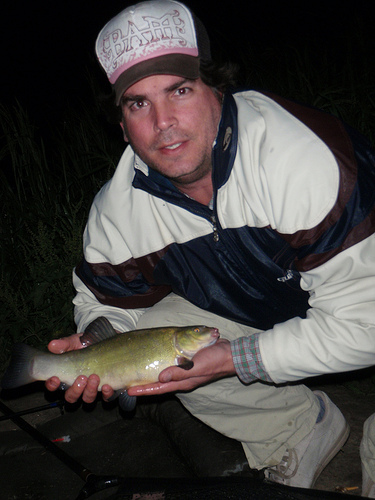

Label:  tench, Tinca tinca
Image:


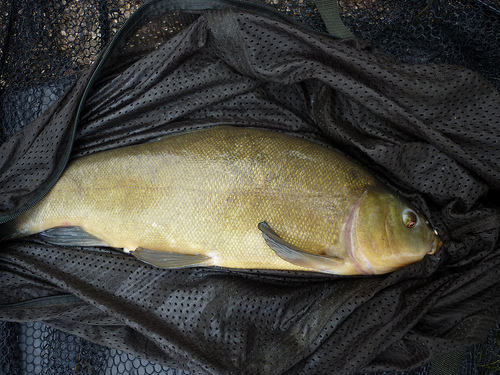

Label:  tench, Tinca tinca
Image:


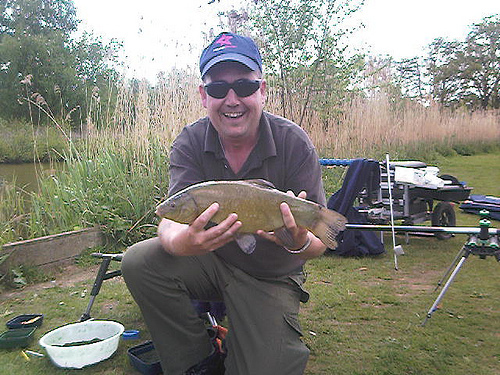

Label:  tench, Tinca tinca
Image:


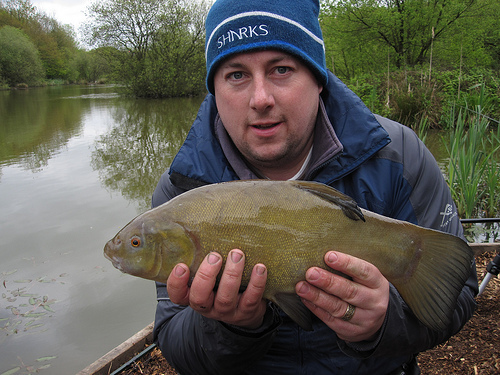

Label:  tench, Tinca tinca
Image:


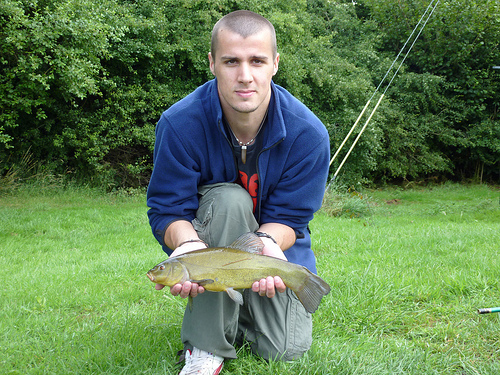

Successfully displayed 5 images.


In [13]:
from PIL import Image
from IPython.display import display


img_count = 0
for image, prediction in zip(prediction_batch["image"], prediction_batch["label"]):
    print("Label: ", prediction)
    print("Image:")
    # Use Jupyter to display the image inline.
    img = Image.fromarray(image)
    display(img)
    img_count += 1
print("Successfully displayed {} images.".format(img_count))

If the samples look good, we can proceed with saving the results to an external storage, e.g., S3 or local disks. See [Ray Data Input/Output](https://docs.ray.io/en/latest/data/api/input_output.html) for all supported storages and file formats.